# Importintg

In [1]:
import pyspark 
import matplotlib.pyplot as plt
import findspark
import pandas as pd
from pyspark.sql.types import *
from pyspark.sql.functions import *
%matplotlib inline
import numpy as np

# Spark setup Check

In [2]:
import findspark

findspark.init()

In [3]:

from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

# df = spark.sql("select 'spark' as hello ")

# df.show()

# Data Read

In [4]:
df= spark.read.load(
    "prodapt/", 
    format="csv", sep=",", inferSchema="true", header="true"
)

In [17]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- location_id: string (nullable = true)
 |-- client_mac: string (nullable = true)
 |-- freq_band: string (nullable = true)
 |-- mac_address: string (nullable = true)
 |-- country: string (nullable = true)
 |-- vendor_name: string (nullable = true)
 |-- rssi_percs_25: double (nullable = true)
 |-- rssi_percs_75: double (nullable = true)
 |-- isp: string (nullable = true)
 |-- total_bytes_tx: double (nullable = true)
 |-- total_bytes_rx: double (nullable = true)
 |-- ts: string (nullable = true)
 |-- txWeightedPhyRate: double (nullable = true)
 |-- rxWeightedPhyRate: double (nullable = true)
 |-- idtype: string (nullable = true)
 |-- is_static: boolean (nullable = true)
 |-- weighted_prr_tx: double (nullable = true)
 |-- weighted_prr_rx: double (nullable = true)
 |-- num_samples: integer (nullable = true)
 |-- is_connected_to_pod: boolean (nullable = true)
 |-- pod_serial: string (nullable = true)
 |-- control_group: string (nullable = true)
 |

In [11]:
df.count()

700596

In [13]:
df.summary()

DataFrame[summary: string, _c0: string, location_id: string, client_mac: string, freq_band: string, mac_address: string, country: string, vendor_name: string, rssi_percs_25: string, rssi_percs_75: string, isp: string, total_bytes_tx: string, total_bytes_rx: string, ts: string, txWeightedPhyRate: string, rxWeightedPhyRate: string, idtype: string, weighted_prr_tx: string, weighted_prr_rx: string, num_samples: string, pod_serial: string, control_group: string, maxMcs: string, maxNss: string, maxChWidth: string, phyMode: string]

Produce a histogram (graph and CSV) for the average Tx and Rx Weighed Phy Rate between -85 and -65 dB in 1 dB steps
(hint: this should produce 21 outputs)

In [50]:
df2.count()

231546

## Filter relevant RSSI values

In [6]:
df2=df.filter(df.rssi_percs_25.between(-85,-65))

In [7]:
df2=df2.select('rssi_percs_25','txWeightedPhyRate','rxWeightedPhyRate')

In [8]:
df2=df2.withColumn("rssi_percs_25", df2["rssi_percs_25"].cast('long'))

In [58]:
df2['rssi_percs_25']

Column<'rssi_percs_25'>

In [74]:
df2.groupBy("rssi_percs_25").count()

DataFrame[rssi_percs_25: bigint, count: bigint]

## Average value of Tx and Rx

In [9]:
df3=df2.groupBy("rssi_percs_25").avg()

In [10]:
df3=df3.toPandas()

In [124]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 14 to 0
Data columns (total 4 columns):
rssi_percs_25             21 non-null int64
avg(rssi_percs_25)        21 non-null float64
avg(txWeightedPhyRate)    21 non-null float64
avg(rxWeightedPhyRate)    21 non-null float64
dtypes: float64(3), int64(1)
memory usage: 840.0 bytes


In [23]:
df3.head()

,rssi_percs_25,avg(rssi_percs_25),avg(txWeightedPhyRate),avg(rxWeightedPhyRate)
14,-85,-85.0,37.979912,18.161817
5,-84,-84.0,42.833057,19.757145
13,-83,-83.0,57.683051,26.123776
4,-82,-82.0,77.174767,33.356074
6,-81,-81.0,97.912595,41.445940


In [11]:
df3.sort_values(by=['rssi_percs_25'],inplace=True)

## Exporting output to CSV

In [19]:
df3.to_csv('histogram_rx_tx.csv',index=False)

## Plotting values

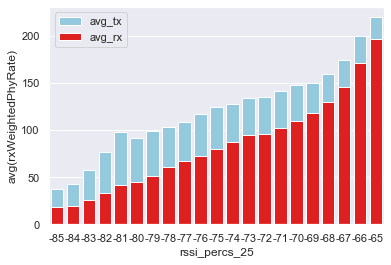

In [22]:
# libraries & dataset
import seaborn as sns
import matplotlib.pyplot as plt
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
df = sns.load_dataset("iris")

sns.barplot(data=df3,x="rssi_percs_25", y="avg(txWeightedPhyRate)", color="skyblue", label="avg_tx")
sns.barplot(data=df3,x="rssi_percs_25", y="avg(rxWeightedPhyRate)", color="red", label="avg_rx")

plt.legend() 
plt.show()

## data ingestion for Grafana visualization

In [ ]:
from elasticsearch import ElasticSearch

df3['@timestamp']=datetime.datetime.utcnow().isoformat()
es= ElasticSearch(["xyz","abc"],
                 use_ssl=True,
                  verify_certs=False,
                  http_auth=('elastic','changeme'),
                  
                 )
for doc in df3.to_dict(orient="records"):
    es.index(index='tx_rx_stats-'+str(datetime.datetime.now().date.strftime('%Y')),doc_type='_doc',body=doc)